In [16]:
# Data Manipulation
import psycopg2
import pandas as pd
import numpy as np
import datetime, time

# Exploratory Data Visualization
import matplotlib.pyplot as plt
import seaborn
import bokeh

# Interactive Graphics

# To communicate with Plotly's server, sign in with credentials file
import plotly.plotly as py

# Useful Python/Plotly tools
import plotly.tools as tls

# Graph objects to piece together plots
from plotly.graph_objs import *

%matplotlib inline

In [17]:
# Setup connection to Pecan Street Dataport
try:
    conn = psycopg2.connect("dbname='postgres' user='2c53Epq3kSyQ' host='dataport.pecanstreet.org' port='5434' password=''")
except:
    "Error: Check there aren't any open connections in notebook or pgAdmin"

In [ ]:
# conn.close()

In [ ]:
# psql -h dataport.pecanstreet.org -p 5434 -U 2c53Epq3kSyQ -W '' postgres

In [69]:
cursor = conn.cursor()

In [ ]:
cursor.execute("SELECT dataid, localhour, SUM(use) FROM university.electricity_egauge_hours GROUP BY dataid, localhour")
for row in cursor:
    print row
    if row == None:
        break

In [18]:
electricity_df = pd.read_sql("SELECT localhour, SUM(use) AS usage, SUM(air1) AS cooling, SUM(furnace1) AS heating, \
                             SUM(car1) AS electric_vehicle \
                             FROM university.electricity_egauge_hours \
                             WHERE dataid = 114 AND use > 0 \
                             GROUP BY dataid, localhour \
                             ORDER BY localhour", conn)

In [19]:
electricity_df['localhour'] = electricity_df.localhour.apply(pd.to_datetime)

In [20]:
electricity_df.set_index('localhour', inplace=True)

In [21]:
electricity_df.fillna(value=0.0, inplace=True)

In [49]:
# Min: 2013-10-16 00:00:00
# Max: 2016-02-26 08:00:00
electricity_df.count()

usage               20721
cooling             20721
heating             20721
electric_vehicle    20721
dtype: int64

In [46]:
electricity_df_nocar = electricity_df[electricity_df.columns[:3]]

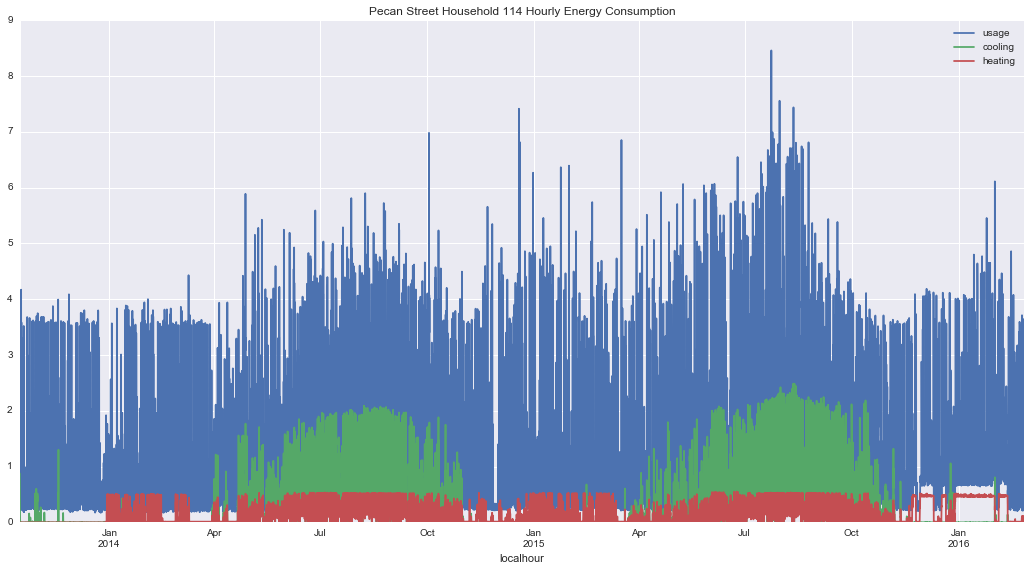

In [47]:
electricity_df_nocar.plot(figsize=(18,9), title="Pecan Street Household 114 Hourly Energy Consumption");

In [ ]:
# Geohash: 30.292432 -97.699662 Austin, TX

In [24]:
from bokeh.io import output_file, output_notebook
from bokeh.plotting import show
from bokeh.models import GMapPlot, GMapOptions, DataRange1d, PanTool, WheelZoomTool, BoxSelectTool

In [25]:
map_options = GMapOptions(lat=30.292432, lng=-97.699662, map_type="roadmap", zoom=11)

In [26]:
plot = GMapPlot(x_range=DataRange1d(), y_range=DataRange1d(), map_options=map_options, title="Austin, TX")

In [27]:
plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool())

In [28]:
output_notebook()
# output_file("gmap_plot.html")

BokehJS successfully loaded.

In [13]:
show(plot);

In [25]:
weather_df = pd.read_sql("SELECT localhour, temperature \
                             FROM university.weather \
                             WHERE localhour BETWEEN '2013-10-16 00:00:00'::timestamp AND \
                             '2016-02-26 08:00:00'::timestamp \
                             AND latitude = 30.292432 \
                             ORDER BY localhour", conn)

In [26]:
weather_df['localhour'] = weather_df.localhour.apply(pd.to_datetime)

In [27]:
weather_df.set_index('localhour', inplace=True)

In [28]:
weather_df.fillna(value=0.0, inplace=True)

In [48]:
weather_df.count()

temperature    20673
dtype: int64

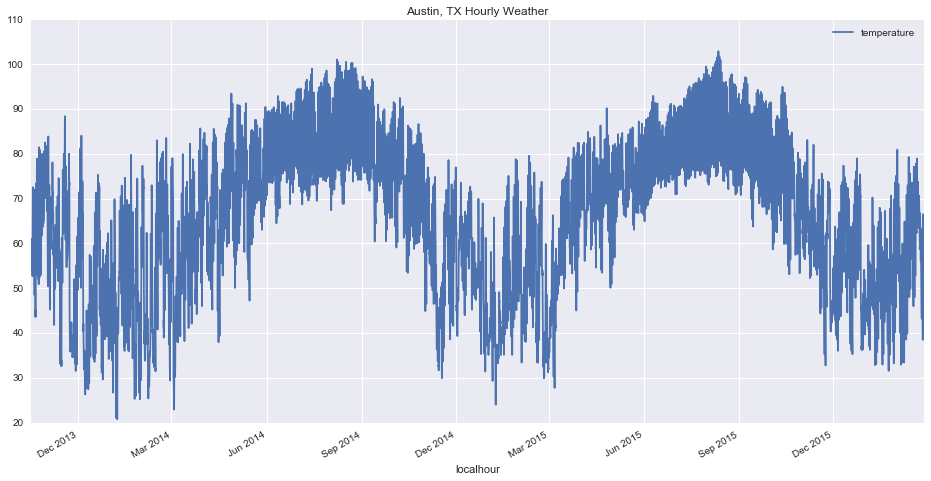

In [29]:
weather_df.plot(figsize=(16,8), title='Austin, TX Hourly Weather');

## Plotly

In [5]:
tls.set_credentials_file(stream_ids=[
        "bcjrhlt0lz",
        "pkkb5aq85l",
        "c5ygaf48l0",
        "l3nh9ls79j"
    ])

In [7]:
stream_ids = tls.get_credentials_file()['stream_ids']
stream_ids

[u'bcjrhlt0lz', u'pkkb5aq85l', u'c5ygaf48l0', u'l3nh9ls79j']

In [9]:
# help(Stream)

In [30]:
electricity = Stream(
    token="pkkb5aq85l",  # (!) link stream id to 'token' key
    maxpoints=500      # (!) keep a max of 80 pts on screen
)

In [31]:
trace1 = Scatter(x=[], y=[], mode='lines+markers', stream=electricity)
data = Data([trace1])

In [32]:
# Add title to layout object
layout = Layout(title='Pecan Street Sensor Data')

# Make a figure object
fig = Figure(data=data, layout=layout)

# (@) Send fig to Plotly, initialize streaming plot, open new tab
py.iplot(fig, filename='Pecan Street Streaming Electricity Usage')

In [36]:
# (@) Make instance of the Stream link object, 
#     with same stream id as Stream id object
s = py.Stream("pkkb5aq85l")

# (@) Open the stream
s.open()

In [37]:
i = 0    # a counter
k = 5    # some shape parameter
N = 200  # number of points to be plotted

# Delay start of stream by 5 sec (time to switch tabs)


while i<N:
    i += 1   # add to counter

    # Current time on x-axis, random numbers on y-axis
    x = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')
    y = (np.cos(k*i/50.)*np.cos(i/50.)+np.random.randn(1))[0]

    # (-) Both x and y are numbers (i.e. not lists nor arrays)

    # (@) write to Plotly stream!
    s.write(dict(x=x, y=y))

    # (!) Write numbers to stream to append current data on plot,
    #     write lists to overwrite existing data on plot (more in 7.2).

    time.sleep(0.08)  # (!) plot a point every 80 ms, for smoother plotting

# (@) Close the stream when done plotting
s.close()

In [33]:
# tls.embed('streaming-demos','12')

In [91]:
class PlotlyStream(object):
    def __init__(self, stream_tokens):
        self.tokens = stream_tokens
    
    def create_plot(self, maxpoints):
        """Method to generate Plotly plot in notebook for rendering streaming data"""
        
        electricity = Stream(token= self.tokens, maxpoints= maxpoints)
        trace1 = Scatter(x=[], y=[], mode='lines+markers', stream=electricity)
        
#         weather = Stream(token= self.tokens[1], maxpoints= maxpoints)
#         trace2 = Scatter(x=[], y=[], mode='lines+markers', stream=weather)
        
        data = Data([trace1]) 
        
        # Initialize layout object and add title
        layout = Layout(title='Pecan Street Sensor Data', showlegend=True)
        
        # Create figure object
        fig = Figure(data=data, layout=layout)
        
        # (@) Send fig to Plotly, initialize streaming plot, open new tab
        return py.iplot(fig, filename='Pecan Street Streaming Electricity Usage')
    
    def plot_stream(self, data, plot_freq=0.1, start_delay=0.5):
        """Method to write data to Plotly servers to render on graph"""
        
        s1 = py.Stream(self.tokens)
#         s2 = py.Stream(self.tokens[1])
        
        s1.open()
#         s2.open()
        
        counter = 0
        N = len(data)
        # Create small delay before plotting begins
#         time.sleep(start_delay)
        gen = data.iterrows()
        while counter < N:
            time, usage = gen.next()
            x1 = time.strftime('%Y-%m-%d %H:%M:%S.%f')
            y1 = usage
#             x = data[0]
#             y = data[1]
            counter += 1
            s1.write(dict(x=x1, y=y1))
#             s2.write(dict(x=x2, y=y2))
#             time.sleep(plot_time)
        
        s1.close()
#         s2.close()

In [92]:
PecanStreet = PlotlyStream("pkkb5aq85l")

In [95]:
PecanStreet.create_plot(100)

In [ ]:
electricity_df_usage = electricity_df[electricity_df.columns[:1]]

In [61]:
def df_generator(data):
    n = len(data)
    counter = 0
    while counter < n:
        yield index, row in data.items

In [68]:
gen = electricity_df_usage.iterrows()

In [97]:
gen.next()

(Timestamp('2013-10-16 09:00:00'), usage    3.604467
 Name: 2013-10-16 09:00:00, dtype: float64)

In [94]:
PecanStreet.plot_stream(electricity_df_usage)

KeyboardInterrupt: 

## Amazon RDS (Postgres)

## Amazon Kinesis